In [1]:
import os
import random
import shutil
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
import os
import random
from glob import glob
import wandb
from tqdm import tqdm

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

In [2]:
wandb.login(key="c2495856d9d06f4cad1ad47b0f49bfef71560762")

wandb: Currently logged in as: xiaomeng9061. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/mxiao/.netrc


True

In [2]:
path = '/var/scratch/mxiao/data/'
os.chdir(path)

In [5]:
!ls model/test/Abena

Abena_10.png  Abena_13.png  Abena_16.png  Abena_2.png  Abena_4.png  Abena_7.png


In [4]:
#train
!find model/train -type f \( -iname \*.jpg -o -iname \*.jpeg -o -iname \*.png \) | wc -l

35642


In [5]:
#val
!find model/val -type f \( -iname \*.jpg -o -iname \*.jpeg -o -iname \*.png \) | wc -l

5955


In [6]:
#test
!find model/test -type f \( -iname \*.jpg -o -iname \*.jpeg -o -iname \*.png \) | wc -l

17958


In [3]:
classes = []
num_imgs = []
train_path = "model/train"
train_folders = sorted(glob(train_path+'/*'))
for path in train_folders:
    class_name = path.split('/')[-1]
    classes.append(class_name)
    
    num = len(glob(path+'/*'))
    num_imgs.append(num)
    
# plt.figure(figsize=(15,5))
# sns.barplot(x=classes, y=num_imgs)
# plt.title('Number of images in each class (train)')
# plt.xticks(rotation=90)
# plt.show()

In [4]:
# Config device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
# Random seeds
def set_seed(seed=0):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
set_seed()

In [6]:
transform=transforms.Compose([
#         transforms.RandomRotation(10),      # rotate +/- 10 degrees
#         transforms.RandomHorizontalFlip(),  # reverse 50% of images
#         transforms.RandomVerticalFlip(p=0.5),
# #         transforms.Resize(224),             # resize shortest side to 224 pixels
#         transforms.RandomCrop(size=(224,224),pad_if_needed=True),          # crop longest side to 224 pixels at center
        transforms.RandomCrop(size=(100,100))
        ,transforms.ToTensor()
])

In [7]:
train_dataset=datasets.ImageFolder(root=("model/train"),transform=transform)
dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [23]:
from tqdm import tqdm

dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
pop_mean = []
pop_std0 = []
pop_std1 = []
for i, (image,label) in tqdm(enumerate(dataloader), total=len(dataloader)):
    # shape (batch_size, 3, height, width)
    numpy_image = image.numpy()
    
    # shape (3,)
    batch_mean = np.mean(numpy_image, axis=(0,2,3))
    batch_std0 = np.std(numpy_image, axis=(0,2,3))
    batch_std1 = np.std(numpy_image, axis=(0,2,3), ddof=1)
    
    pop_mean.append(batch_mean)
    pop_std0.append(batch_std0)
    pop_std1.append(batch_std1)

# shape (num_iterations, 3) -> (mean across 0th axis) -> shape (3,)
pop_mean = np.array(pop_mean).mean(axis=0)
pop_std0 = np.array(pop_std0).mean(axis=0)
pop_std1 = np.array(pop_std1).mean(axis=0)

print(pop_mean)
print(pop_std0)
print(pop_std1)

100%|███████████████████████████████████████████████████████████████████████████████| 1114/1114 [13:30<00:00,  1.37it/s]

[0.6195012 0.6195012 0.6195012]
[0.3307451 0.3307451 0.3307451]
[0.33074555 0.33074555 0.33074555]


In [ ]:
mean=[0.6195012,0.6195012,0.6195012]
std=[0.3307451,0.3307451,0.3307451]

In [8]:
# normalize = transforms.Normalize(mean=[0.53997546,0.53997546,0.53997546], std=[0.36844322,0.36844322,0.36844322])
normalize = transforms.Normalize(mean=[0.6195012,0.6195012,0.6195012], std=[0.3307451,0.3307451,0.3307451])

In [16]:
train_transforms = transforms.Compose([
#         transforms.RandomRotation(10),      # rotate +/- 10 degrees
#         transforms.RandomHorizontalFlip(),  # reverse 50% of images
#         transforms.RandomVerticalFlip(p=0.5),
#         transforms.Resize(224),             # resize shortest side to 224 pixels
#         transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.RandomCrop(size=(224,224),pad_if_needed=True), 
        transforms.ToTensor(),
#         normalize
    ])

test_transforms = transforms.Compose([
        transforms.RandomCrop((224,224),pad_if_needed=True),
        transforms.ToTensor(),
#         normalize
    ])

In [17]:
train_dataset=datasets.ImageFolder(root=("model/train"),transform=train_transforms)
val_dataset=datasets.ImageFolder(root=("model/val"),transform=test_transforms)
test_dataset=datasets.ImageFolder(root=("model/test"),transform=test_transforms)

In [18]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 35642
    Root location: model/train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(224, 224), padding=None)
               ToTensor()
           )

In [11]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False,num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,num_workers=4)

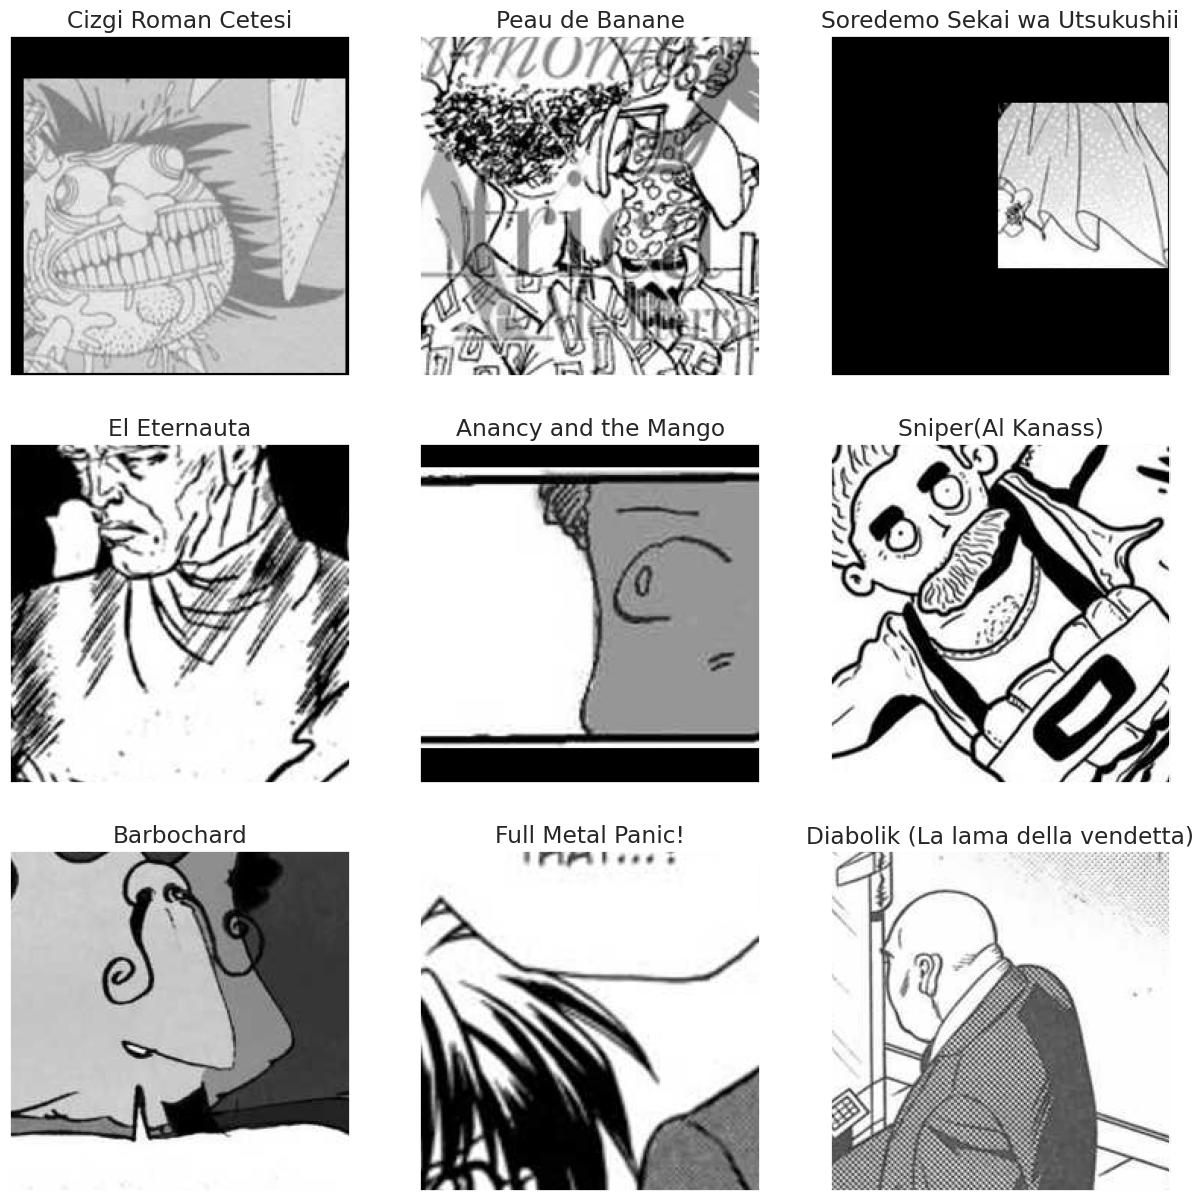

In [33]:
plot_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Visualise some examples
plt.figure(figsize=(15,15))
for i in range(9):
    ax = plt.subplot(3,3,i+1)
    ax.grid(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    batch = next(iter(plot_loader))
    label = int(batch[1].numpy()[0])
    image = np.transpose(batch[0][0].numpy(), (1, 2, 0))
    plt.imshow(image)
    plt.title(classes[label])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


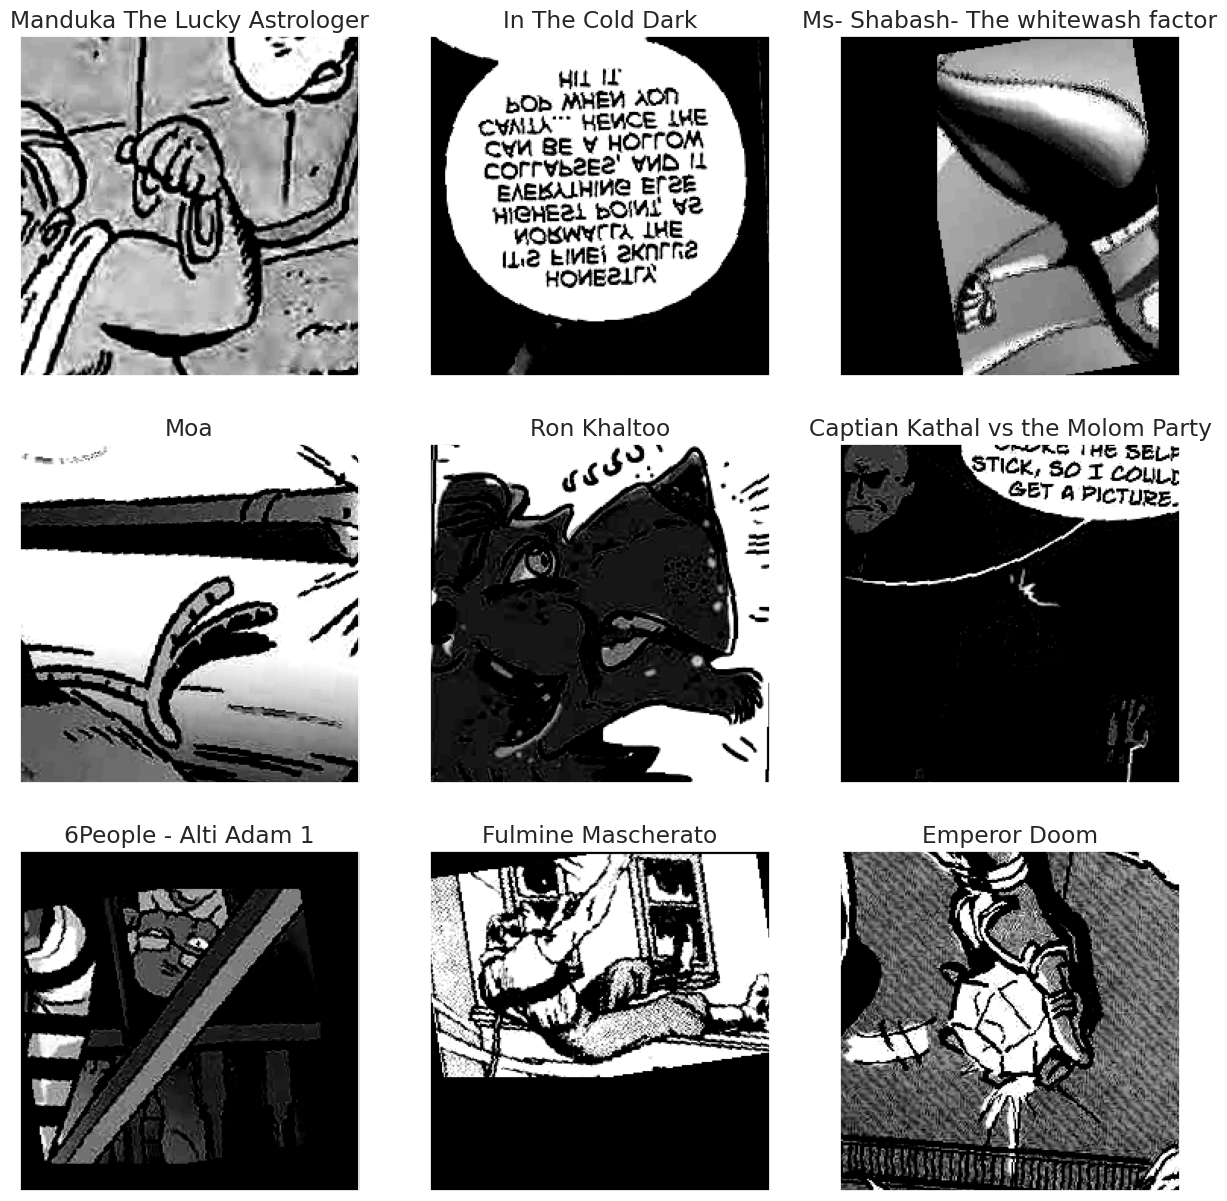

In [37]:
plot_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Visualise some examples
plt.figure(figsize=(15,15))
for i in range(9):
    ax = plt.subplot(3,3,i+1)
    ax.grid(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    batch = next(iter(plot_loader))
    label = int(batch[1].numpy()[0])
    image = np.transpose(batch[0][0].numpy(), (1, 2, 0))
    plt.imshow(image)
    plt.title(classes[label])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


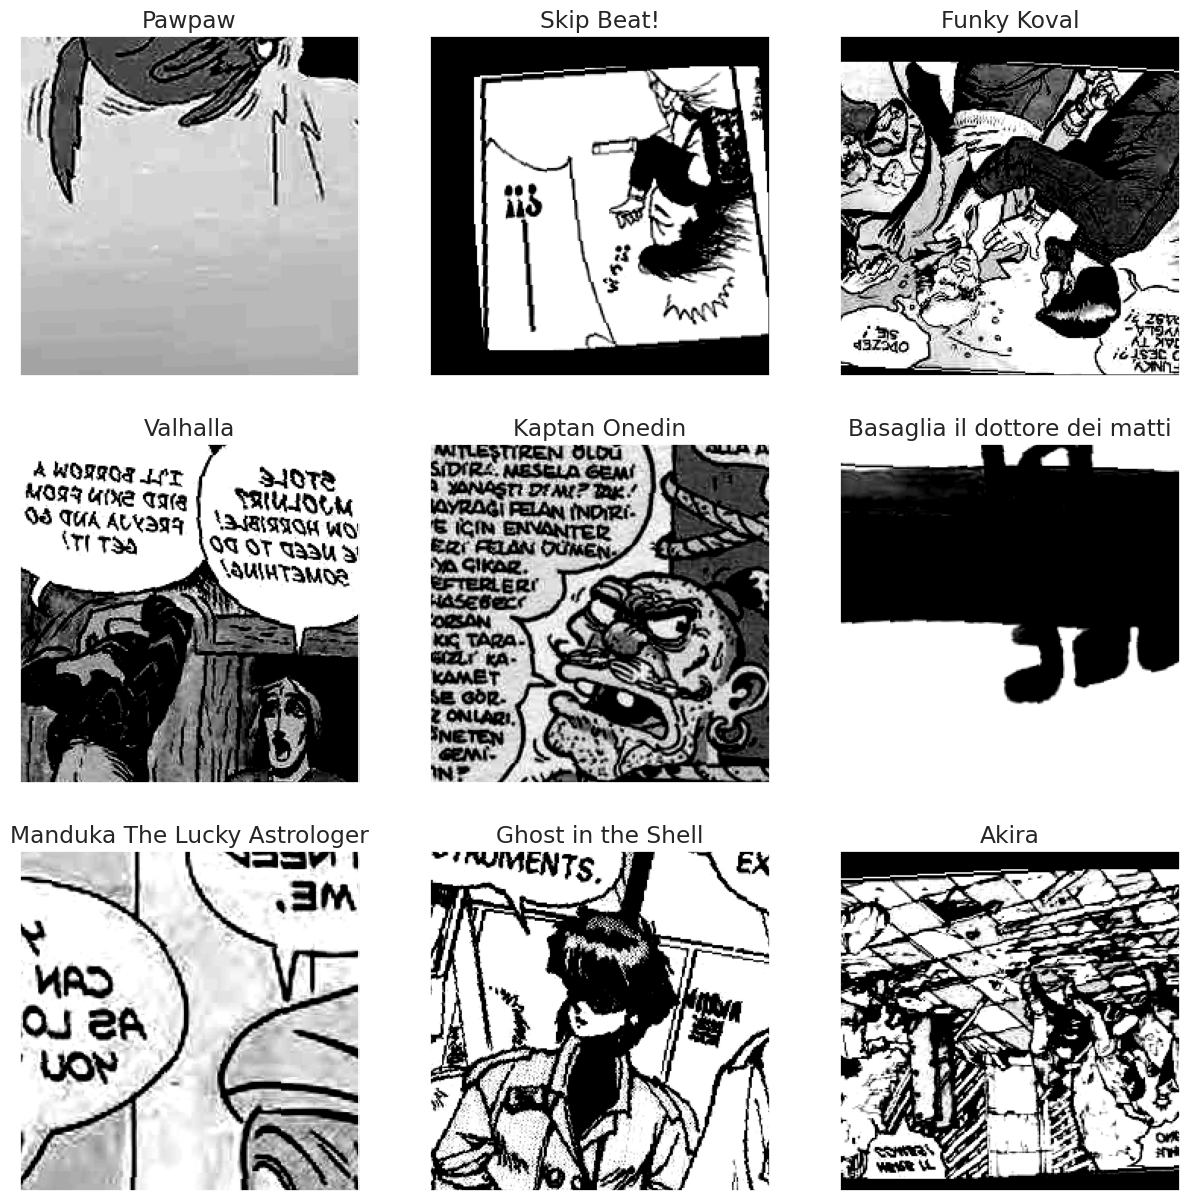

In [125]:
plot_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Visualise some examples
plt.figure(figsize=(15,15))
for i in range(9):
    ax = plt.subplot(3,3,i+1)
    ax.grid(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    batch = next(iter(plot_loader))
    label = int(batch[1].numpy()[0])
    image = np.transpose(batch[0][0].numpy(), (1, 2, 0))
    plt.imshow(image)
    plt.title(classes[label])
plt.show()

### Pretrain Model

In [40]:
for batch_id, data in enumerate(train_loader):
      # data will be dict 
        print(batch_id,data)
        break

0 [tensor([[[[ 1.1504,  1.1504,  1.1504,  ..., -1.8138, -1.8730, -1.0075],
          [ 1.1504,  1.1504,  1.1504,  ..., -1.8730, -1.8730, -1.0075],
          [ 1.1504,  1.1504,  1.1504,  ..., -1.8138, -1.1854,  0.8896],
          ...,
          [ 1.1504,  1.1504,  1.0437,  ...,  1.1504,  1.1504,  1.1504],
          [ 1.1504,  1.1030,  1.1504,  ...,  1.1504,  1.1504,  1.1504],
          [ 1.1504,  1.1267,  1.1504,  ...,  1.1504,  1.1504,  1.1504]],

         [[ 1.1504,  1.1504,  1.1504,  ..., -1.8138, -1.8730, -1.0075],
          [ 1.1504,  1.1504,  1.1504,  ..., -1.8730, -1.8730, -1.0075],
          [ 1.1504,  1.1504,  1.1504,  ..., -1.8138, -1.1854,  0.8896],
          ...,
          [ 1.1504,  1.1504,  1.0437,  ...,  1.1504,  1.1504,  1.1504],
          [ 1.1504,  1.1030,  1.1504,  ...,  1.1504,  1.1504,  1.1504],
          [ 1.1504,  1.1267,  1.1504,  ...,  1.1504,  1.1504,  1.1504]],

         [[ 1.1504,  1.1504,  1.1504,  ..., -1.8138, -1.8730, -1.0075],
          [ 1.1504,  1.1504

In [142]:
# 是否要冻住模型的前面一些层
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        model = model
        for param in model.parameters():
            param.requires_grad = False
# resnet34模型
def res_model(num_classes, feature_extract = False, use_pretrained=True):

    model_ft = models.resnet101(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, num_classes))

    return model_ft

In [143]:
# 超参数
learning_rate = 1e-5
weight_decay = 1e-3
num_epoch = 40
model_path = './pre_res_model3.ckpt'
# model = models.resnet50(pretrained=True)
model = models.resnet101(pretrained=True)

/var/scratch/mxiao/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /home/mxiao/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|████████████████████████████████████████████████████████████████████████████████| 171M/171M [00:04<00:00, 41.4MB/s]


In [59]:
# Initialize a model, and put it on the device specified.
model = model.to(device)
model.device = device
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)

# The number of training epochs.
n_epochs = num_epoch

best_acc = 0.0
for epoch in range(n_epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train() 
    # These are used to record information in training.
    train_loss = []
    train_accs = []
    # Iterate the training set by batches.
    for batch in tqdm(train_loader):
        # A batch consists of image data and corresponding labels.
        imgs, labels1 = batch
        imgs = imgs.to(device)
        labels = torch.tensor(tuple(int(i) for i in labels1)).to(device)
        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs)
        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels)
        
        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()
        # Compute the gradients for parameters.
        loss.backward()
        # Update the parameters with computed gradients.
        optimizer.step()
        
        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)
        
    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")
    
    
    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()
    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []
    
    # Iterate the validation set by batches.
    for batch in tqdm(val_loader):
        imgs, labels1 = batch
        labels = torch.tensor(tuple(int(i) for i in labels1)).to(device)
        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))
            
        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        
    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")
    
    # if the model improves, save a checkpoint at this epoch
    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save(model.state_dict(), model_path)
        print('saving model with acc {:.3f}'.format(best_acc))

NameError: name 'learning_rate' is not defined

  0%|                                                                                           | 0/562 [00:00<?, ?it/s]


AttributeError: 'list' object has no attribute 'to'

### part2

In [12]:
CFG = dict(
        batch_size = 32,
        learning_rate = 0.001,
        epochs = 40,
        lin1_size = 1024,
        lin2_size = 1024,
        activation = 'relu',
        model = 'resnet50'
#         model = 'resnet101'
)

In [13]:
model.classifier[1].out_features

NameError: name 'model' is not defined

In [15]:
model.fc= torch.nn.Linear(in_features=model.classifier[1].in_features, out_features=len(classes), bias=True)

In [25]:
model.fc

AttributeError: 'Sequential' object has no attribute 'fc'

In [13]:
# Resnet training
# Load the ResNet50 model pre-trained on ImageNet
model = models.resnet101(pretrained=True).to(device)
# Freeze the layers of the ResNet50 model
for param in model.parameters():
    param.requires_grad = False

# Add a new classification head to the model
model.fc = nn.Sequential(nn.Linear(2048, CFG['lin1_size']),
                         nn.ReLU(),
                         nn.Linear(CFG['lin2_size'], len(classes))).to(device)


/var/scratch/mxiao/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/var/scratch/mxiao/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
from efficientnet_pytorch import EfficientNet

# Step 1: Load the pre-trained model without the classification head
# pretrained_model = models.efficientnet_v2_s(pretrained=True)
# pretrained_model = models.resnet50(pretrained=True)
pretrained_model = EfficientNet.from_pretrained('efficientnet-b0')
pretrained_model.fc = nn.Identity()  # Remove the original classification head

# Step 2: Freeze the parameters of the pre-trained model
for param in pretrained_model.parameters():
    param.requires_grad = False

# Step 3: Add a new fully connected layer on top of the pre-trained model
num_classes = 748  # Number of classes in your new classification task
new_classifier = nn.Sequential(
    nn.Linear(1000, 512),    # Adjust the input size (2048) based on the pre-trained model's output
    nn.ReLU(),
    nn.Linear(512, num_classes)
)

# Step 4: Combine the pre-trained model with the new classifier
model = nn.Sequential(
    pretrained_model,
    new_classifier
).to(device)

Loaded pretrained weights for efficientnet-b0


In [15]:
model

Sequential(
  (0): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePadding(
     

In [14]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters())

# Learning rate scheduler
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=CFG['epochs'])

In [15]:
def train_one_epoch(train_loader, model, criterion, optimizer, scheduler):
    # Train mode
    model.train()
    
    # Track metrics
    loss_epoch = 0
    accuracy_epoch = 0
    
    # Loop over minibatches
    for inputs, labels in tqdm(train_loader):
        # Send to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
#         loss.requires_grad = True
        # Backprop
        loss.backward()

        # Update parameters
        optimizer.step()

        # Zero gradients
        optimizer.zero_grad()

        # Track loss
        loss_epoch += loss.detach().item()
        
        # Accuracy
        _, preds = torch.max(outputs, 1)
        accuracy_epoch += torch.sum(preds == labels)/inputs.shape[0]
        
    # Update learning rate
    scheduler.step()
        
    return loss_epoch/len(train_loader), accuracy_epoch.item()/len(train_loader)

In [16]:
def evaluate_one_epoch(test_loader, model, criterion):
    # Eval mode
    model.eval()
    
    # Track metrics
    loss_epoch = 0
    accuracy_epoch = 0
    
    # Don't update weights
    with torch.no_grad():
        # Loop over minibatches
        for inputs, labels in tqdm(test_loader):
            # Send to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Track loss
            loss_epoch += loss.detach().item()
            
            # Accuracy
            _, preds = torch.max(outputs, 1)
            accuracy_epoch += torch.sum(preds == labels)/inputs.shape[0]
    
    return loss_epoch/len(test_loader), accuracy_epoch.item()/len(test_loader)

In [17]:
# Plot history
def plot_hist(train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist):    
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.plot(train_loss_hist, label='Train_Loss')
    plt.plot(test_loss_hist, label='Test_loss')
    plt.title('Cross Entropy Loss')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(train_acc_hist, label='Train_Accuracy')
    plt.plot(test_acc_hist, label='Val_Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

In [18]:
def train_model(model, criterion, optimizer, scheduler, train_loader, test_loader, verbose=True):
    # Initialise outputs
    train_loss_hist = []
    test_loss_hist = []
    train_acc_hist = []
    test_acc_hist = []
    best_acc = 0.0
    model_path = './pre_effi_model_v1.pth'
    
    # Loop over epochs
    for epoch in range(CFG['epochs']):
        # Train
        train_loss, train_accuracy = train_one_epoch(train_loader, model, criterion, optimizer, scheduler)
        
        # Evaluate
        test_loss, test_accuracy = evaluate_one_epoch(test_loader, model, criterion)
        
        # Track metrics
        train_loss_hist.append(train_loss)
        test_loss_hist.append(test_loss)
        train_acc_hist.append(train_accuracy)
        test_acc_hist.append(test_accuracy)
        
        # Log metrics
        wandb.log({
        'epoch': epoch,
        'train_loss': train_loss,
        'test_loss': test_loss,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy
        })
        
        if test_accuracy > best_acc:
            best_acc = test_accuracy
            torch.save(model.state_dict(), model_path) 
            print('saving model with acc {:.3f}'.format(best_acc))
            
        # Print loss
        if verbose:
            if (epoch+1)%1==0:
                print(f'Epoch {epoch+1}/{CFG["epochs"]}, loss {train_loss:.5f}, test_loss {test_loss:.5f}, accuracy {train_accuracy:.5f}, test_accuracy {test_accuracy:.5f}')
    
    return train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist

In [19]:
# Initialise run
run = wandb.init(
                 project = 'comic-classification',
                 config = CFG,
                 save_code = True)

In [20]:
# Train model
train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist = train_model(model, criterion, optimizer, scheduler, train_loader, test_loader, verbose=True)

100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:33<00:00,  6.00it/s]


saving model with acc 0.152
Epoch 1/40, loss 5.38262, test_loss 4.30624, accuracy 0.06851, test_accuracy 0.15163


100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:34<00:00,  5.97it/s]


saving model with acc 0.255
Epoch 2/40, loss 3.91609, test_loss 3.53059, accuracy 0.19948, test_accuracy 0.25534


100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:35<00:00,  5.91it/s]


saving model with acc 0.303
Epoch 3/40, loss 3.42914, test_loss 3.20245, accuracy 0.26938, test_accuracy 0.30271


100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:35<00:00,  5.91it/s]


saving model with acc 0.345
Epoch 4/40, loss 3.17581, test_loss 2.99935, accuracy 0.30485, test_accuracy 0.34520


100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:34<00:00,  5.92it/s]


saving model with acc 0.354
Epoch 5/40, loss 3.02010, test_loss 2.92489, accuracy 0.33584, test_accuracy 0.35409


100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:34<00:00,  5.92it/s]


saving model with acc 0.376
Epoch 6/40, loss 2.92031, test_loss 2.82317, accuracy 0.34834, test_accuracy 0.37561


100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:34<00:00,  5.94it/s]


saving model with acc 0.389
Epoch 7/40, loss 2.83397, test_loss 2.72730, accuracy 0.36522, test_accuracy 0.38949


100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:34<00:00,  5.94it/s]


Epoch 8/40, loss 2.76718, test_loss 2.77808, accuracy 0.37732, test_accuracy 0.38417


100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:34<00:00,  5.97it/s]


saving model with acc 0.408
Epoch 9/40, loss 2.71459, test_loss 2.66921, accuracy 0.38532, test_accuracy 0.40773


100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:34<00:00,  5.93it/s]


saving model with acc 0.413
Epoch 10/40, loss 2.66424, test_loss 2.61324, accuracy 0.39613, test_accuracy 0.41289


100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:35<00:00,  5.91it/s]


saving model with acc 0.420
Epoch 11/40, loss 2.64825, test_loss 2.56641, accuracy 0.40057, test_accuracy 0.41978


100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:35<00:00,  5.91it/s]


saving model with acc 0.427
Epoch 12/40, loss 2.61736, test_loss 2.55505, accuracy 0.40425, test_accuracy 0.42682


100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:34<00:00,  5.96it/s]


Epoch 13/40, loss 2.56014, test_loss 2.54830, accuracy 0.41530, test_accuracy 0.42397


100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:35<00:00,  5.92it/s]


saving model with acc 0.433
Epoch 14/40, loss 2.53129, test_loss 2.49419, accuracy 0.42003, test_accuracy 0.43335


100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:34<00:00,  5.92it/s]


saving model with acc 0.445
Epoch 15/40, loss 2.50323, test_loss 2.47343, accuracy 0.42439, test_accuracy 0.44538


100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:35<00:00,  5.90it/s]


saving model with acc 0.449
Epoch 16/40, loss 2.48615, test_loss 2.42236, accuracy 0.43075, test_accuracy 0.44886


100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:35<00:00,  5.90it/s]


Epoch 17/40, loss 2.45957, test_loss 2.50758, accuracy 0.43485, test_accuracy 0.43932


100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:34<00:00,  5.92it/s]


saving model with acc 0.457
Epoch 18/40, loss 2.42579, test_loss 2.41605, accuracy 0.44127, test_accuracy 0.45746


100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:35<00:00,  5.91it/s]


saving model with acc 0.458
Epoch 19/40, loss 2.41033, test_loss 2.38042, accuracy 0.44717, test_accuracy 0.45802


100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:34<00:00,  5.96it/s]


saving model with acc 0.466
Epoch 20/40, loss 2.38560, test_loss 2.36584, accuracy 0.45268, test_accuracy 0.46571


100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:35<00:00,  5.91it/s]


saving model with acc 0.474
Epoch 21/40, loss 2.36242, test_loss 2.33479, accuracy 0.45323, test_accuracy 0.47392


100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:34<00:00,  5.96it/s]


saving model with acc 0.476
Epoch 22/40, loss 2.35918, test_loss 2.31939, accuracy 0.45746, test_accuracy 0.47607


100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:35<00:00,  5.90it/s]


Epoch 23/40, loss 2.33063, test_loss 2.33096, accuracy 0.46548, test_accuracy 0.47081


100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:34<00:00,  5.92it/s]


Epoch 24/40, loss 2.31284, test_loss 2.32276, accuracy 0.46967, test_accuracy 0.47509


100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:35<00:00,  5.90it/s]


saving model with acc 0.484
Epoch 25/40, loss 2.30271, test_loss 2.27702, accuracy 0.46940, test_accuracy 0.48413


100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:35<00:00,  5.90it/s]


saving model with acc 0.487
Epoch 26/40, loss 2.26781, test_loss 2.27867, accuracy 0.47429, test_accuracy 0.48673


100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:34<00:00,  5.93it/s]


saving model with acc 0.488
Epoch 27/40, loss 2.26326, test_loss 2.25662, accuracy 0.47888, test_accuracy 0.48834


100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:34<00:00,  5.92it/s]


saving model with acc 0.489
Epoch 28/40, loss 2.24639, test_loss 2.26315, accuracy 0.48313, test_accuracy 0.48875


100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:34<00:00,  5.96it/s]


saving model with acc 0.499
Epoch 29/40, loss 2.22941, test_loss 2.20749, accuracy 0.48661, test_accuracy 0.49935


100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:34<00:00,  5.93it/s]


Epoch 30/40, loss 2.21757, test_loss 2.25981, accuracy 0.48887, test_accuracy 0.48823


100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:35<00:00,  5.92it/s]


Epoch 31/40, loss 2.21391, test_loss 2.22505, accuracy 0.49057, test_accuracy 0.49731


100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:34<00:00,  5.92it/s]


Epoch 32/40, loss 2.19345, test_loss 2.22672, accuracy 0.49577, test_accuracy 0.49741


100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:35<00:00,  5.90it/s]


saving model with acc 0.503
Epoch 33/40, loss 2.18448, test_loss 2.20963, accuracy 0.49784, test_accuracy 0.50323


100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:34<00:00,  5.97it/s]


Epoch 34/40, loss 2.17152, test_loss 2.22030, accuracy 0.50293, test_accuracy 0.49514


100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:35<00:00,  5.90it/s]


Epoch 35/40, loss 2.16972, test_loss 2.18152, accuracy 0.50301, test_accuracy 0.50237


100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:35<00:00,  5.89it/s]


saving model with acc 0.505
Epoch 36/40, loss 2.17001, test_loss 2.20981, accuracy 0.50109, test_accuracy 0.50489


100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:34<00:00,  5.95it/s]


Epoch 37/40, loss 2.15538, test_loss 2.23941, accuracy 0.50531, test_accuracy 0.49889


100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:35<00:00,  5.91it/s]


Epoch 38/40, loss 2.15214, test_loss 2.19400, accuracy 0.50429, test_accuracy 0.50285


100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:34<00:00,  5.95it/s]


saving model with acc 0.509
Epoch 39/40, loss 2.14224, test_loss 2.17986, accuracy 0.50731, test_accuracy 0.50899


100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:35<00:00,  5.91it/s]

Epoch 40/40, loss 2.14045, test_loss 2.18149, accuracy 0.50916, test_accuracy 0.50866


In [59]:
test_acc_hist

[0.28964635231316727,
 0.3458629893238434,
 0.38309978335777634,
 0.3913108038308357,
 0.40812202535065895,
 0.41599941593047984,
 0.4276579181494662,
 0.43034550133973254,
 0.4374443950177936,
 0.4426342024073482,
 0.45019647998741935,
 0.4586484101319228,
 0.4581479652920652,
 0.47330960854092524,
 0.47062205250152916,
 0.4793149466192171,
 0.4803158362989324,
 0.485394406573204,
 0.4925118442956239,
 0.49825772865811274,
 0.507469584509147,
 0.5113805044588245,
 0.5126223309608541,
 0.5182569510571897,
 0.5321952846975089,
 0.527765403014485,
 0.541184774921458,
 0.5358096085409253,
 0.5458926272137734,
 0.5478758896797153,
 0.5482466076616714,
 0.5505078407369051,
 0.5541221645803214,
 0.556049822064057,
 0.5592749110320284,
 0.561665925266904,
 0.5608689386225256,
 0.5649095311283641,
 0.5612396023027413,
 0.5618142233200345]

In [54]:
# Save model
torch.save(model.state_dict(), 'efficientnet_b0_aug.pth')

# Save model as an Artifact
artifact = wandb.Artifact(name='efficientnet_b0_aug', type='model')
artifact.add_file('efficientnet_b0_aug.pth')
run.log_artifact(artifact)

In [55]:
torch.save(model.state_dict(), 'efficientnet_b0.pth')

In [56]:
!ls

best_model.pt		    pair_comic.csv
best_test_model.pth	    PML_v2
best_test_modelv2.pth	    PML_v3
best_tpl_model.pt	    PML_v4
Comic			    pre_effi_b0_model_v1.pth
Comic files		    pre_effi_model_v1.pth
cropped_panels		    pre_res101_model1.pth
efficientnet_b0.pth	    pre_res50_model_v2.pth
example_logs		    pre_res_model3.ckpt
example_tensorboard	    pretrained
FashionMNIST		    resnet50.pth
filename_less_10_panel.csv  resnet.h5
logs.db			    TINTINCorpus_data_112622.xlsx
MAST_export_04032023.csv    visualizations
model			    wandb


In [57]:
# Complete W&B run
run.finish()

In [36]:
plot_hist(train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist)

NameError: name 'train_loss_hist' is not defined